# LSTM + AE



# [1] 쉬운 예제

## 1.환경준비

### (1) 라이브러리 로딩

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from sklearn.preprocessing import MinMaxScaler

from keras.models import Model, Sequential
from keras.layers import Input, Dense, LSTM, RepeatVector, TimeDistributed
from keras.backend import clear_session
from keras.optimizers import Adam

### (2) 데이터셋

In [2]:
# 간단한 데이터 생성
x = np.array([[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
                       [0.1**3, 0.2**3, 0.3**3, 0.4**3, 0.5**3, 0.6**3, 0.7**3, 0.8**3, 0.9**3]]).transpose()
y = np.zeros(9)

timesteps = x.shape[0]
n_features = x.shape[1]
x

array([[0.1  , 0.001],
       [0.2  , 0.008],
       [0.3  , 0.027],
       [0.4  , 0.064],
       [0.5  , 0.125],
       [0.6  , 0.216],
       [0.7  , 0.343],
       [0.8  , 0.512],
       [0.9  , 0.729]])

### (3) 필요 함수들 생성

* 시계열 데이터 분석을 위한 전처리(for LSTM, CNN)

In [3]:
def temporalize(x, y, timestep):
    output_X = []
    output_y = []
    for i in range(len(x) - timestep + 1 ):
        t = []
        for j in range(timestep):
            t.append(x[[(i + j)], :])
        output_X.append(t)
        output_y.append(y[i + timestep - 1])
    return np.squeeze(np.array(output_X)), np.array(output_y)

## 2.데이터 준비
* 3차원 데이터셋으로 만들어 봅시다.

In [4]:
x

array([[0.1  , 0.001],
       [0.2  , 0.008],
       [0.3  , 0.027],
       [0.4  , 0.064],
       [0.5  , 0.125],
       [0.6  , 0.216],
       [0.7  , 0.343],
       [0.8  , 0.512],
       [0.9  , 0.729]])

In [5]:
timesteps = 3
x1, y1 = temporalize(x, y, timesteps)

In [6]:
x1.shape, y1.shape

((7, 3, 2), (7,))

In [7]:
x1

array([[[0.1  , 0.001],
        [0.2  , 0.008],
        [0.3  , 0.027]],

       [[0.2  , 0.008],
        [0.3  , 0.027],
        [0.4  , 0.064]],

       [[0.3  , 0.027],
        [0.4  , 0.064],
        [0.5  , 0.125]],

       [[0.4  , 0.064],
        [0.5  , 0.125],
        [0.6  , 0.216]],

       [[0.5  , 0.125],
        [0.6  , 0.216],
        [0.7  , 0.343]],

       [[0.6  , 0.216],
        [0.7  , 0.343],
        [0.8  , 0.512]],

       [[0.7  , 0.343],
        [0.8  , 0.512],
        [0.9  , 0.729]]])

## 3.모델링 : LSTM+AE



In [8]:
x1.shape

(7, 3, 2)

In [ ]:
n_features =  x1.shape[2] # 2

In [9]:
clear_session()

# Encoder - Decoder
lstm_ae = Sequential( [LSTM(128, input_shape = (timesteps, n_features), return_sequences=True),
                       LSTM(64, return_sequences=False),
                       RepeatVector(timesteps),
                       LSTM(64, return_sequences=True),
                       LSTM(128, return_sequences=True),
                       TimeDistributed(Dense(n_features))])

# input_layer = Input(shape=(timesteps, n_features))
# encoder = LSTM(128, return_sequences=True)(input_layer)
# encoder = LSTM(64, return_sequences=False)(encoder)
# encoder = RepeatVector(timesteps)(encoder)

# # Decoder
# decoder = LSTM(64, return_sequences=True)(encoder)
# decoder = LSTM(128, return_sequences=True)(decoder)
# decoder = TimeDistributed(Dense(n_features))(decoder)
# lstm_ae = Model(inputs=input_layer, outputs=decoder)

lstm_ae.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 3, 128)            67072     
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 repeat_vector (RepeatVector  (None, 3, 64)            0         
 )                                                               
                                                                 
 lstm_2 (LSTM)               (None, 3, 64)             33024     
                                                                 
 lstm_3 (LSTM)               (None, 3, 128)            98816     
                                                                 
 time_distributed (TimeDistr  (None, 3, 2)             258       
 ibuted)                                                

In [10]:
lstm_ae.compile(optimizer='adam', loss = 'mse')
lstm_ae.fit(x1, x1, epochs=50, batch_size=5, verbose=0)

pred = lstm_ae.predict(x1)
print('---Predicted---')
print(np.round(pred,3))
print('---Actual---')
print(np.round(x1, 3))

1/1 [==============================] - 1s 1s/step
---Predicted---
[[[ 0.176  0.011]
  [ 0.255  0.003]
  [ 0.295 -0.006]]

 [[ 0.218  0.028]
  [ 0.325  0.038]
  [ 0.373  0.044]]

 [[ 0.274  0.052]
  [ 0.409  0.086]
  [ 0.463  0.112]]

 [[ 0.35   0.087]
  [ 0.512  0.153]
  [ 0.563  0.204]]

 [[ 0.453  0.139]
  [ 0.633  0.247]
  [ 0.666  0.331]]

 [[ 0.589  0.215]
  [ 0.761  0.374]
  [ 0.76   0.499]]

 [[ 0.753  0.319]
  [ 0.876  0.533]
  [ 0.827  0.706]]]
---Actual---
[[[0.1   0.001]
  [0.2   0.008]
  [0.3   0.027]]

 [[0.2   0.008]
  [0.3   0.027]
  [0.4   0.064]]

 [[0.3   0.027]
  [0.4   0.064]
  [0.5   0.125]]

 [[0.4   0.064]
  [0.5   0.125]
  [0.6   0.216]]

 [[0.5   0.125]
  [0.6   0.216]
  [0.7   0.343]]

 [[0.6   0.216]
  [0.7   0.343]
  [0.8   0.512]]

 [[0.7   0.343]
  [0.8   0.512]
  [0.9   0.729]]]


-------

# [2] pulp-and-paper mill 공정 데이터

## 1.환경준비

### (1) 라이브러리 로딩

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from keras.models import Model, load_model, Sequential
from keras.layers import Input, Dense, LSTM, RepeatVector, TimeDistributed
from keras.backend import clear_session
from keras.optimizers import Adam

### (2) 필요 함수들 생성

#### 1) reconstruction error plot

> * input과 output의 차이(mse)를 계산하고
* 시각화 합니다.



In [12]:
def recon_err_plot(x, x_pred, y, threshold=0):
    # treshold : 우리가 지정해줘야 함.(어떻게?)

    # 재구성 오차 계산 : 3차원
    mse = np.mean(np.power(x.reshape(x.shape[0], -1) - x_pred.reshape(x_pred.shape[0], -1), 2), axis=1)
    error_df = pd.DataFrame({'recon_err': mse, 'y': y})
    error_df = error_df.reset_index()

    # 재구성 오차 그래프
    groups = error_df.groupby('y')
    fig, ax = plt.subplots()
    for name, group in groups:
        ax.plot(group.index, group.recon_err, marker='o', ms=3.5, linestyle='',
                label= "Abnormal" if name == 1 else "Normal")
    ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
    ax.legend()
    plt.title("Reconstruction error for each data point")
    plt.ylabel("Reconstruction error")
    plt.xlabel("Data point index")
    plt.show()

    return error_df

#### 2) precision, recall, f1 curve

> * sklearn에서는 precision, recall curve만 제공됩니다.
* 그래서, f1 curve도 추가해서 구하고, plot을 그립니다.



In [13]:
def prec_rec_f1_curve(y, score, pos = 1) :
    precision, recall, thresholds  = precision_recall_curve(y, score, pos_label=1)
    f1 = 2 / (1/precision + 1/recall)

    plt.figure(figsize = (8, 6))
    plt.plot(thresholds, np.delete(precision, -1), label = 'precision')
    plt.plot(thresholds, np.delete(recall, -1), label = 'recall')
    plt.plot(thresholds, np.delete(f1, -1), label = 'f1')
    plt.xlabel('Anomaly Score')
    plt.legend()
    plt.grid()
    plt.show()

    return precision, recall, f1, thresholds

#### 3) threshold로 잘랐을 때, 분류 평가 함수


In [14]:
from sklearn.metrics import confusion_matrix, classification_report

def classification_report2(y, pred, thresholds):
    pred_temp = np.where(pred >= thresholds , 1, 0)
    cm = confusion_matrix(y, pred_temp)
    print('< confusion matrix >\n')
    print(cm)
    print('\n' + '='*60 + '\n')

    print('< classification_report >\n')
    print(classification_report(y, pred_temp))

    return cm

#### 4) DL 학습곡선 그리기


In [15]:
def plot_learning_curve(history) :
    plt.figure(figsize = (10,6))
    plt.plot(history['loss'], label='Train', marker = '.')
    plt.plot(history['val_loss'], label='Validation', marker = '.')

    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.grid()
    plt.show()

#### 5) 시계열 데이터 분석을 위한 데이터구조 만들기(for LSTM, CNN)

In [16]:
def temporalize(x, y, timestep):
    output_X = []
    output_y = []
    for i in range(len(x) - timestep + 1):
        t = []
        for j in range(timestep):
            t.append(x[[(i + j)], :])
        output_X.append(t)
        output_y.append(y[i + timestep - 1])
    return np.squeeze(np.array(output_X)), np.array(output_y)

### (3) 데이터셋 불러오기

In [17]:
# 공정 데이터 불러오기
path = "https://raw.githubusercontent.com/DA4BAM/dataset/master/processminer3.csv"
data = pd.read_csv(path)
data.head()

,y,time,x1,x2,x3,x4,x5,x6,x7,x8,...,x51,x52,x53,x54,x55,x56,x57,x58,x59,x60
0,0.0,1999-05-01 00:00:00,0.376665,-4.596435,-4.095756,13.497687,-0.118830,-20.669883,0.000732,-0.061114,...,29.984624,10.091721,0.053279,-4.936434,-24.590146,18.515436,3.473400,0.033444,0.953219,0.006076
1,0.0,1999-05-01 00:02:00,0.475720,-4.542502,-4.018359,16.230659,-0.128733,-18.758079,0.000732,-0.061114,...,29.984624,10.095871,0.062801,-4.937179,-32.413266,22.760065,2.682933,0.033536,1.090502,0.006083
2,0.0,1999-05-01 00:04:00,0.363848,-4.681394,-4.353147,14.127997,-0.138636,-17.836632,0.010803,-0.061114,...,29.984624,10.100265,0.072322,-4.937924,-34.183774,27.004663,3.537487,0.033629,1.840540,0.006090
3,0.0,1999-05-01 00:06:00,0.301590,-4.758934,-4.023612,13.161566,-0.148142,-18.517601,0.002075,-0.061114,...,29.984624,10.104660,0.081600,-4.938669,-35.954281,21.672449,3.986095,0.033721,2.554880,0.006097
4,0.0,1999-05-01 00:08:00,0.265578,-4.749928,-4.333150,15.267340,-0.155314,-17.505913,0.000732,-0.061114,...,29.984624,10.109054,0.091121,-4.939414,-37.724789,21.907251,3.601573,0.033777,1.410494,0.006105


## 2.데이터 준비

### (1) 불필요한 변수 제거

불필요한 변수 제거 : time

In [18]:
data.drop('time', axis=1, inplace=True)

In [19]:
data.shape

(12143, 60)

### (2) x,y 분할

In [20]:
target = 'y'
input_x = data.drop(target, axis = 1).values
input_y = data['y'].values

### (3) 스케일링

In [21]:
scaler = MinMaxScaler()
input_x = scaler.fit_transform(input_x)

### (4) 3차원 데이터로 변환
* timestep에 맞게 data point를 2차원으로 변환  
(data point : 2차원 ==> data set : 3차원)

In [22]:
timestep = 10
x, y = temporalize(input_x, input_y, timestep)

In [23]:
x.shape, y.shape

((12134, 10, 59), (12134,))

### (5) 데이터셋 분할

In [26]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=6000, random_state=20)

### (6) Normal 분리 : Normal 데이터로만 학습하기 위해서

In [27]:
x_train0 = x_train[y_train==0]
x_train0.shape

(6056, 10, 59)

## 3.모델링



### (1) LSTM + AE ①
* 다음과 같이 구조를 정의하시오.
    * lstm(64)
    * lstm(32)
    * RepeatVector(  )
    * lstm(32)
    * lstm(64)
    * TimeDistributed(Dense(  ))

* 모델이름 : model1


In [28]:
_, timesteps, n_features = x_train0.shape
timesteps, n_features

(10, 59)

In [ ]:
clear_session()

model1 = Sequential( [LSTM(64, input_shape = (timesteps, n_features), return_sequences=True ),
                       LSTM(32 , return_sequences = False),
                       RepeatVector(timesteps),
                       LSTM(32, return_sequences=True ),
                       LSTM(64, return_sequences=True ),
                       TimeDistributed(Dense(n_features))])
model1.summary()

* 학습
    * epochs : 50~100

In [30]:
model1.compile(optimizer= Adam(learning_rate = 0.01)  , loss = 'mse')
hist = model1.fit(x_train0, x_train0, epochs = 50, validation_split=.2).history

Epoch 1/50
152/152 [==============================] - 9s 22ms/step - loss: 0.0282 - val_loss: 0.0215
Epoch 2/50
152/152 [==============================] - 1s 9ms/step - loss: 0.0208 - val_loss: 0.0217
Epoch 3/50
152/152 [==============================] - 1s 9ms/step - loss: 0.0206 - val_loss: 0.0222
Epoch 4/50
152/152 [==============================] - 1s 9ms/step - loss: 0.0207 - val_loss: 0.0216
Epoch 5/50
152/152 [==============================] - 1s 9ms/step - loss: 0.0206 - val_loss: 0.0218
Epoch 6/50
152/152 [==============================] - 2s 11ms/step - loss: 0.0206 - val_loss: 0.0214
Epoch 7/50
152/152 [==============================] - 2s 12ms/step - loss: 0.0193 - val_loss: 0.0185
Epoch 8/50
152/152 [==============================] - 1s 9ms/step - loss: 0.0171 - val_loss: 0.0176
Epoch 9/50
152/152 [==============================] - 1s 9ms/step - loss: 0.0133 - val_loss: 0.0121
Epoch 10/50
152/152 [==============================] - 1s 9ms/step - loss: 0.0110 - val_loss: 0.0

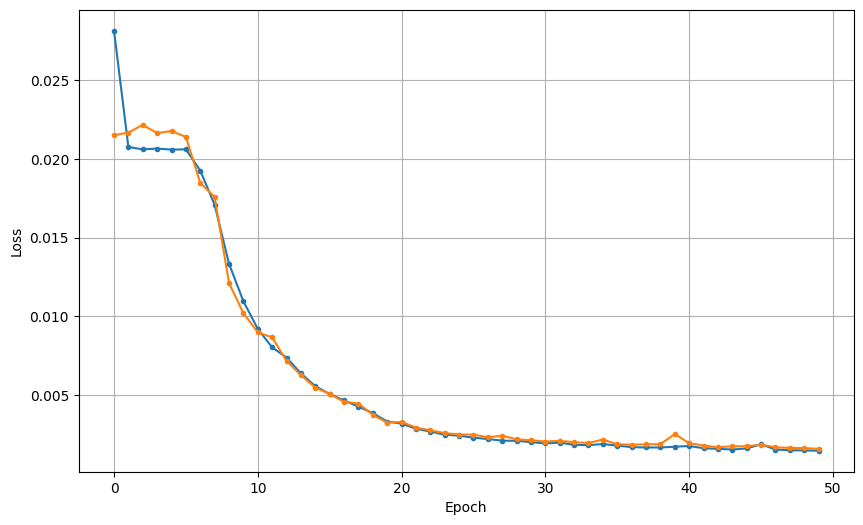

In [31]:
plot_learning_curve(hist)

### (2) LSTM + AE ②
* RepeatVector 제외 모델
* 1번과 동일한 구조로 모델링을 수행하되, RepeatVector를 제외하고 수행합니다.
* RepeatVector를 제외하게 되면 바로 전 LSTM 층에서, return_sequences = True 이어야 합니다.
* 모델이름 : model2


In [32]:
clear_session()

model2 = Sequential( [LSTM(64, input_shape = (timesteps, n_features), return_sequences=True ),
                       LSTM(32 , return_sequences = True),
                    #    RepeatVector(timesteps),
                       LSTM(32, return_sequences=True ),
                       LSTM(64, return_sequences=True ),
                       TimeDistributed(Dense(n_features))])
model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10, 64)            31744     
                                                                 
 lstm_1 (LSTM)               (None, 10, 32)            12416     
                                                                 
 lstm_2 (LSTM)               (None, 10, 32)            8320      
                                                                 
 lstm_3 (LSTM)               (None, 10, 64)            24832     
                                                                 
 time_distributed (TimeDistr  (None, 10, 59)           3835      
 ibuted)                                                         
                                                                 
Total params: 81,147
Trainable params: 81,147
Non-trainable params: 0
____________________________________________________

* 학습
    * epochs : 50~100

In [33]:
model2.compile(optimizer= Adam(learning_rate = 0.01)  , loss = 'mse')
hist = model2.fit(x_train0, x_train0, epochs = 50, validation_split=.2).history

Epoch 1/50
152/152 [==============================] - 8s 22ms/step - loss: 0.0275 - val_loss: 0.0223
Epoch 2/50
152/152 [==============================] - 1s 9ms/step - loss: 0.0203 - val_loss: 0.0190
Epoch 3/50
152/152 [==============================] - 1s 9ms/step - loss: 0.0168 - val_loss: 0.0155
Epoch 4/50
152/152 [==============================] - 1s 9ms/step - loss: 0.0143 - val_loss: 0.0150
Epoch 5/50
152/152 [==============================] - 1s 9ms/step - loss: 0.0136 - val_loss: 0.0129
Epoch 6/50
152/152 [==============================] - 1s 9ms/step - loss: 0.0114 - val_loss: 0.0111
Epoch 7/50
152/152 [==============================] - 1s 9ms/step - loss: 0.0098 - val_loss: 0.0096
Epoch 8/50
152/152 [==============================] - 1s 9ms/step - loss: 0.0087 - val_loss: 0.0085
Epoch 9/50
152/152 [==============================] - 2s 11ms/step - loss: 0.0069 - val_loss: 0.0065
Epoch 10/50
152/152 [==============================] - 2s 11ms/step - loss: 0.0061 - val_loss: 0.0

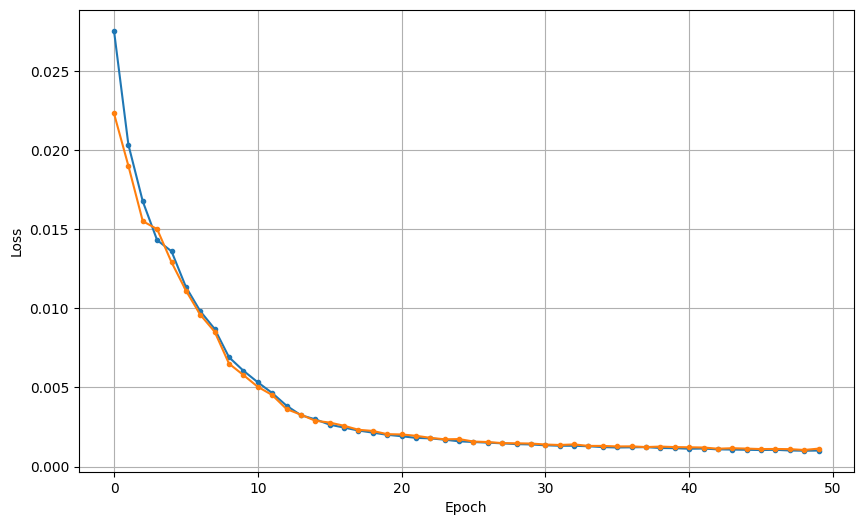

In [34]:
plot_learning_curve(hist)

### (3) 분류에 대한 평가

#### 1) LSTM + AE ①

① 예측

In [35]:
pred1 = model1.predict(x_val)

188/188 [==============================] - 2s 5ms/step


② 재구성 오차

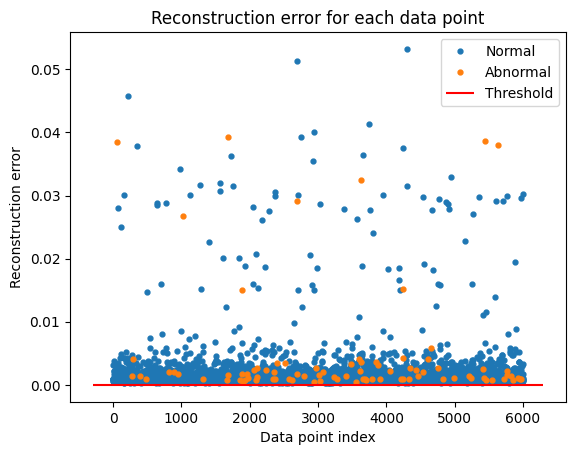

In [36]:
result1 = recon_err_plot(x_val, pred1, y_val)

In [37]:
result1.head()

,index,recon_err,y
0,0,0.000648,0.0
1,1,0.000993,0.0
2,2,0.000944,0.0
3,3,0.000696,0.0
4,4,0.000866,0.0


③ 최적의 cut-off 찾기
* threshold 값을 조절하면서, precision, recall, f1 score 그래프를 그려 봅시다.

<ipython-input-13-0b309618100c>:3: RuntimeWarning: divide by zero encountered in true_divide
  f1 = 2 / (1/precision + 1/recall)


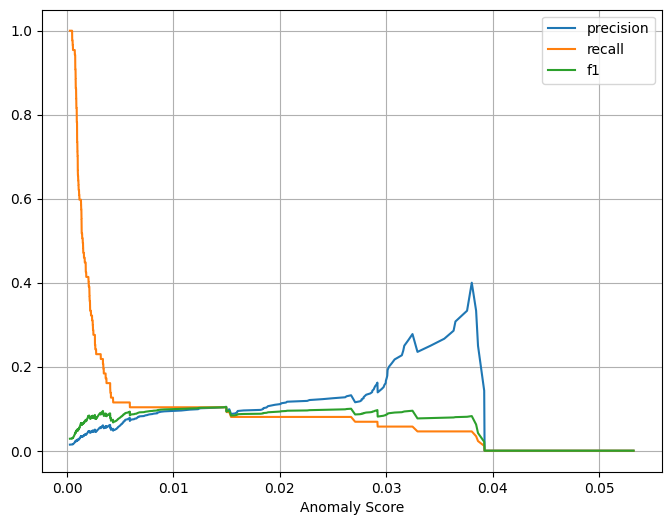

In [38]:
_, _, f1_1, thresholds_1 = prec_rec_f1_curve(result1['y'], result1['recon_err'])

* f1 score를 가장 높이는 thresholds 값을 찾고 평가해 봅시다.

In [39]:
thres_f1_max_1 = thresholds_1[np.argmax(f1_1)]
thres_f1_max_1

0.014959865398861487

④ 잘라서 평가

In [40]:
cm1 = classification_report2(result1['y'], result1['recon_err'], thres_f1_max_1)

< confusion matrix >

[[5836   77]
 [  78    9]]


< classification_report >

              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99      5913
         1.0       0.10      0.10      0.10        87

    accuracy                           0.97      6000
   macro avg       0.55      0.55      0.55      6000
weighted avg       0.97      0.97      0.97      6000



#### 2) LSTM + AE ②

① 예측

In [41]:
pred2 = model2.predict(x_val)

188/188 [==============================] - 4s 6ms/step


② 재구성 오차

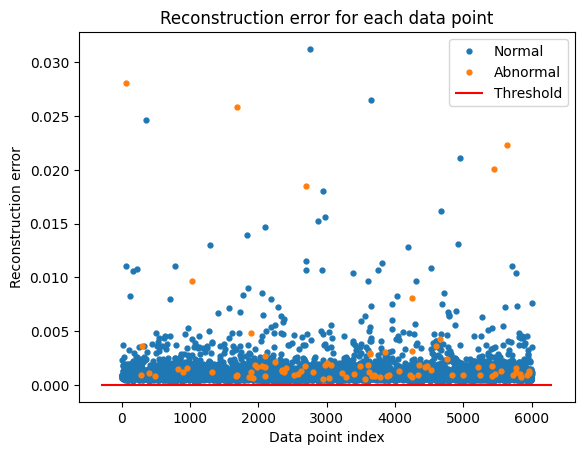

In [42]:
result2 = recon_err_plot(x_val, pred2, y_val)

③ 최적의 cut-off 찾기
* threshold 값을 조절하면서, precision, recall, f1 score 그래프를 그려 봅시다.

<ipython-input-13-0b309618100c>:3: RuntimeWarning: divide by zero encountered in true_divide
  f1 = 2 / (1/precision + 1/recall)


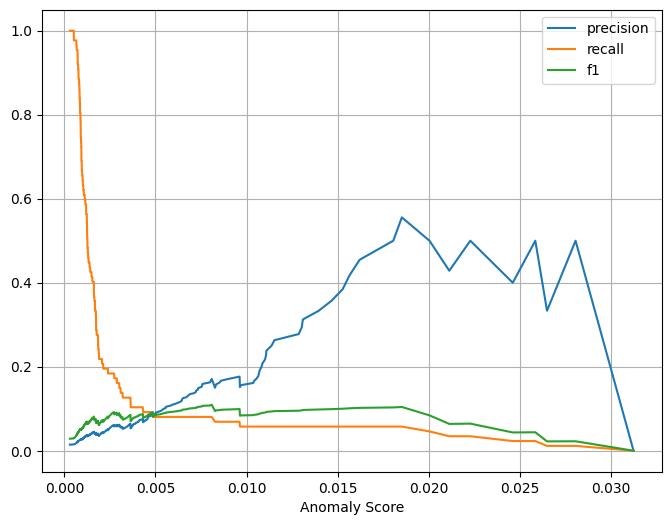

In [43]:
_, _, f1_2, thresholds_2 = prec_rec_f1_curve(result2['y'], result2['recon_err'])

* f1 score를 가장 높이는 thresholds 값을 찾고 평가해 봅시다.

In [44]:
thres_f1_max_2 = thresholds_2[np.argmax(f1_2)]
thres_f1_max_2

0.008088522381506522

④ 잘라서 평가

In [45]:
cm2 = classification_report2(result2['y'], result2['recon_err'], thres_f1_max_2)

< confusion matrix >

[[5879   34]
 [  80    7]]


< classification_report >

              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99      5913
         1.0       0.17      0.08      0.11        87

    accuracy                           0.98      6000
   macro avg       0.58      0.54      0.55      6000
weighted avg       0.97      0.98      0.98      6000



## 4.비즈니스 관점에서의 모델 평가

> * 한 롤로 종이를 말다가 찢어지는 사고가 하루에 한번 정도 발생.
* 이때마다 공정 중단 및 수율 저하 등, 평균적으로 100백만원의 손실이 발생
* 이를 사전에 감지하는 것은 굉장히 어려움. 이런 사고를 5%만 감소시키더라도 회사 입장에서는 상당한 비용 절감효과 예상.
* 장애가 예상된다면, 속도를 줄여 장애를 예방할 수 있다. 단, 속도를 줄이면 생산성이 저하되므로, 1회당 평균 3만원의 손실이 발생됩니다.


### (1) 비즈니스 기대가치 매트릭스

In [46]:
bv = np.array([[0,3],[100,3]])
bv

array([[  0,   3],
       [100,   3]])

### (2) cost 계산

* base cost 계산 : 두가지로 계산할 필요가 있습니다.
    * 1) 예방활동을 하지 않고, 장애 발생에 대한 조치 비용 계산(계산가능!)
    * 2) 현재 수행중인 예방활동 비용 + 장애발생 비용 계산(이 부분은 현재 모르므로 여기서는 다루지 않음)

In [47]:
base_cost = result1['y'].sum() * 100
base_cost

8700.0

* 예측값에 대한 cost 계산

In [48]:
cost1 = []
for v in thresholds_1 :
    y_pred = np.where(result1['recon_err']> v, 1, 0)
    cm1 = confusion_matrix(result1['y'], y_pred)
    cost1.append(np.sum(cm1 * bv))

cost1 = np.array(cost1)

In [49]:
cost2 = []
for v in thresholds_2 :
    y_pred2 = np.where(result2['recon_err']> v, 1, 0)
    cm2 = confusion_matrix(result2['y'], y_pred2)
    cost2.append(np.sum(cm2 * bv))

cost2 = np.array(cost2)

### (3) 평가해봅시다.

* LSTM+AE

Anomaly Score : 0.00201,  Min Cost : 7434


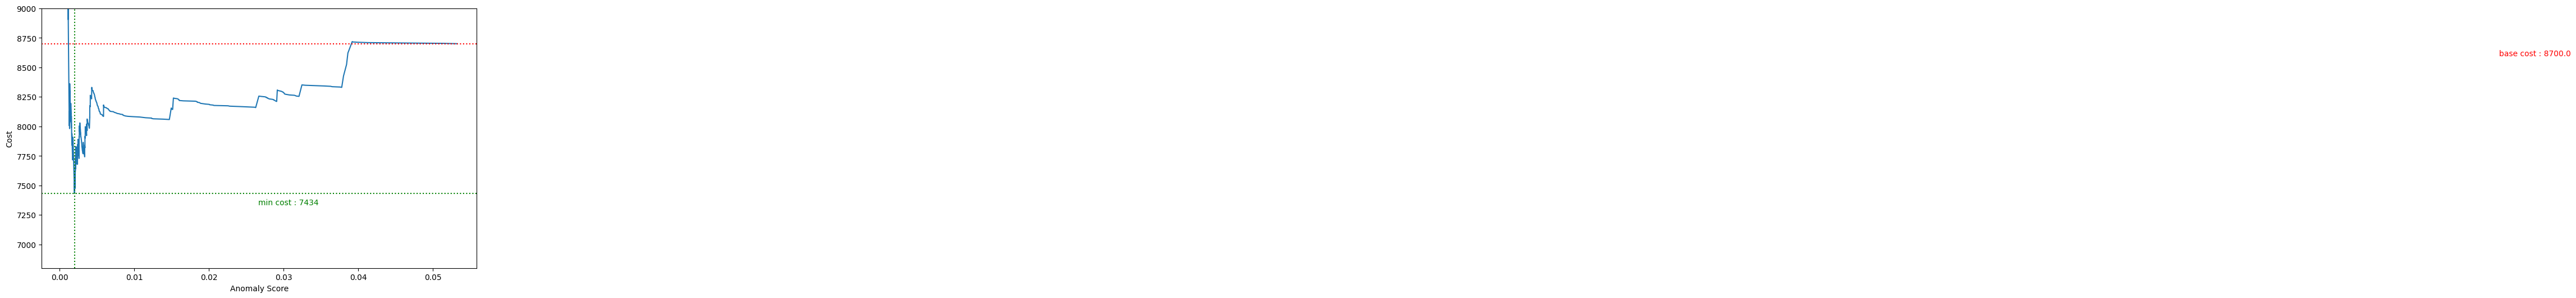

In [50]:
min_tres = round(thresholds_1[np.argmin(cost1)],5)

print(f'Anomaly Score : {min_tres},  Min Cost : {min(cost1)}' )
plt.figure(figsize = (10, 6))
plt.plot(thresholds_1, cost1)

plt.axhline(base_cost, color = 'r', linestyle = ":")
plt.axhline(min(cost1), color = 'g', linestyle = ":")
plt.axvline(min_tres, color = 'g', linestyle = ":")

plt.text(max(thresholds_1)/2+ 0.3, base_cost-100, f"base cost : {base_cost}", color = 'r')
plt.text(max(thresholds_1)/2, min(cost1)-100, f"min cost : {min(cost1)}", color = 'g')

plt.ylim(6800, 9000)
plt.xlabel("Anomaly Score")
plt.ylabel("Cost")

plt.show()

* LSTM+AE2

Anomaly Score : 0.00162,  Min Cost : 7522


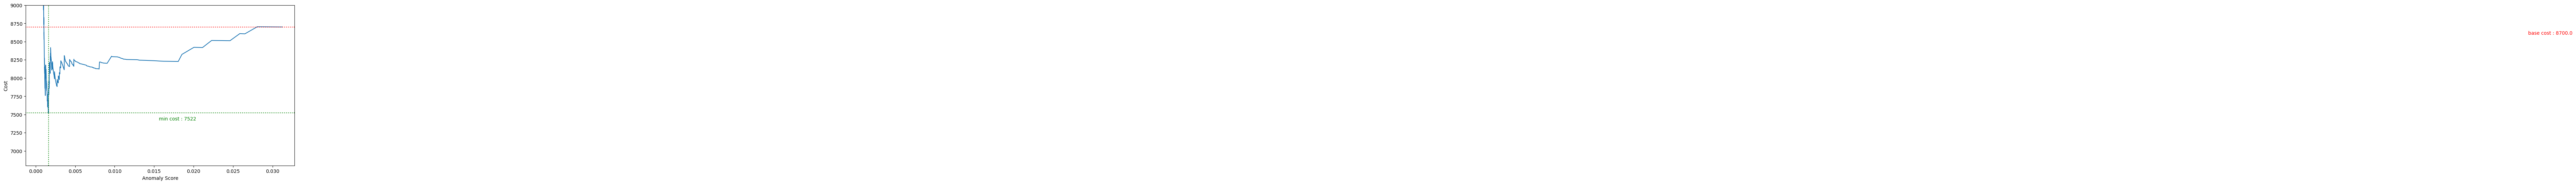

In [51]:
min_tres = round(thresholds_2[np.argmin(cost2)],5)

print(f'Anomaly Score : {min_tres},  Min Cost : {min(cost2)}' )
plt.figure(figsize = (10, 6))
plt.plot(thresholds_2, cost2)

plt.axhline(base_cost, color = 'r', linestyle = ":")
plt.axhline(min(cost2), color = 'g', linestyle = ":")
plt.axvline(min_tres, color = 'g', linestyle = ":")

plt.text(max(thresholds_2)/2+ 0.3, base_cost-100, f"base cost : {base_cost}", color = 'r')
plt.text(max(thresholds_2)/2, min(cost2)-100, f"min cost : {min(cost2)}", color = 'g')

plt.ylim(6800, 9000)
plt.xlabel("Anomaly Score")
plt.ylabel("Cost")

plt.show()